In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from category_encoders import TargetEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, root_mean_squared_error
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector

In [48]:
url = 'https://raw.githubusercontent.com/goitacademy/MACHINE-LEARNING-NEO/main/datasets/mod_07_topic_13_bigmart_data.csv'
data = pd.read_csv(url)
data.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [49]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


**Item_Identifier** — унікальний ідентифікатор товару,

**Item_Weight** — вага товару,

**Item_Fat_Content** — категорія жирності продукту,

**Item_Visibility** — відсоток від загальної площі викладки всіх товарів у магазині, виділений для конкретного товару,

**Item_Type** — категорія, до якої належить товар,

**Item_MRP** — максимальна роздрібна ціна (прайс-лист) товару,

**Outlet_Identifier** — унікальний ідентифікатор магазину,

**Outlet_Establishment_Year** — рік заснування магазину,

**Outlet_Size** — розмір (площа) магазину.

**Outlet_Location_Type** — тип населеного пункту, в якому знаходиться магазин,

**Outlet_Type** — тип магазину (звичайний продуктовий магазин чи супермаркет).

**Item_Outlet_Sales** — цільова змінна, продажі товару в конкретному магазині.

In [50]:
data['Outlet_Establishment_Year'] = 2013 - data['Outlet_Establishment_Year']

In [51]:
data['Item_Visibility'] = (data['Item_Visibility'].mask(data['Item_Visibility'].eq(0), np.nan))
data['Item_Visibility_Avg'] = (data.groupby(['Outlet_Type', 'Item_Type'])['Item_Visibility'].transform('mean'))
data['Item_Visibility'] = data['Item_Visibility'].fillna(data['Item_Visibility_Avg'])
data['Item_Visibility_Ratio'] = data['Item_Visibility'] / data['Item_Visibility_Avg']
data[['Item_Visibility', 'Item_Visibility_Ratio']].describe()

,Item_Visibility,Item_Visibility_Ratio
count,8523.000000,8523.000000
mean,0.070440,1.000000
std,0.048885,0.643141
min,0.003575,0.053965
25%,0.033085,0.489270
50%,0.060700,0.891396
75%,0.096335,1.367361
max,0.328391,3.418374


In [52]:
data['Item_Fat_Content'].unique()

array(['Low Fat', 'Regular', 'low fat', 'LF', 'reg'], dtype=object)

In [53]:
data['Item_Fat_Content'] = data['Item_Fat_Content'].replace({'LF': 'Low Fat', 'reg': 'Regular', 'low fat': 'Low Fat'})

In [54]:
data['Item_Identifier'].unique()

array(['FDA15', 'DRC01', 'FDN15', ..., 'NCF55', 'NCW30', 'NCW05'],
      shape=(1559,), dtype=object)

In [55]:
data['Item_Identifier_Type'] = data['Item_Identifier'].str[:2]
data['Item_Identifier_Type'].unique()

array(['FD', 'DR', 'NC'], dtype=object)

In [56]:
data_num = data.select_dtypes(include=np.number)
data_cat = data.select_dtypes(include='object')

X_train_num, X_test_num, X_train_cat, X_test_cat, y_train, y_test = train_test_split(data_num.drop(['Item_Outlet_Sales', 'Item_Visibility_Avg'], axis=1), data_cat.drop(['Item_Identifier'], axis=1), data['Item_Outlet_Sales'], test_size=0.2, random_state=42)

In [57]:
num_imputer = SimpleImputer(strategy='mean').set_output(transform='pandas')
X_train_num = num_imputer.fit_transform(X_train_num)
X_test_num = num_imputer.transform(X_test_num)

cat_imputer = SimpleImputer(strategy='most_frequent').set_output(transform='pandas')
X_train_cat = cat_imputer.fit_transform(X_train_cat)
X_test_cat = cat_imputer.transform(X_test_cat)


In [58]:
enc_auto = TargetEncoder().set_output(transform='pandas')
X_train_cat = enc_auto.fit_transform(X_train_cat, y_train)
X_test_cat = enc_auto.transform(X_test_cat)

In [59]:
X_train_concat = pd.concat([X_train_num, X_train_cat], axis=1)
X_test_concat = pd.concat([X_test_num, X_test_cat], axis=1)

X_train_concat.head()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Visibility_Ratio,Item_Fat_Content,Item_Type,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Identifier_Type
549,9.500,0.035206,171.3448,14.0,0.522019,2232.878028,2321.843277,2382.120509,2301.333706,1895.446358,2336.111149,2237.307754
7757,18.000,0.047473,170.5422,11.0,0.797281,2185.478564,2261.702912,2228.023712,2301.333706,2333.583503,2336.111149,2159.187339
764,17.600,0.076122,111.7202,16.0,1.338587,2232.878028,2191.256377,2287.769449,1929.302214,1895.446358,2336.111149,2237.307754
6867,8.325,0.029845,41.6138,11.0,0.442534,2185.478564,2321.843277,2228.023712,2301.333706,2333.583503,2336.111149,2237.307754
2716,12.850,0.137228,155.5630,16.0,2.086298,2185.478564,2295.101739,2287.769449,1929.302214,1895.446358,2336.111149,2237.307754


## RandomForestRegressor

In [60]:
clf = (RandomForestRegressor(random_state=42).fit(X_train_concat, y_train))
pred_clf = clf.predict(X_test_concat)
rmse_clf = root_mean_squared_error(y_test, pred_clf)
print(f"Prototype's RMSE on test: {rmse_clf:.1f}")

Prototype's RMSE on test: 1066.8


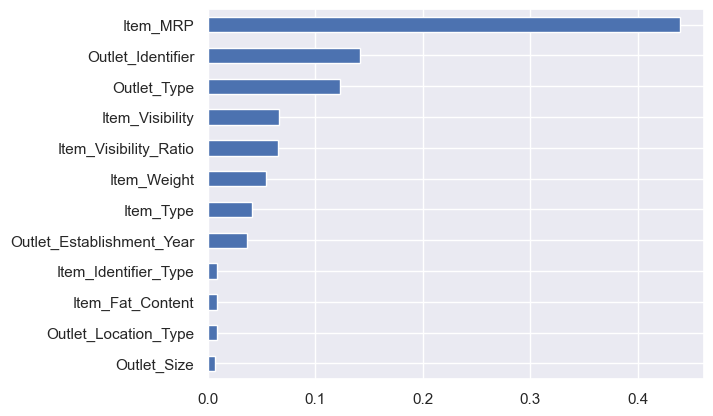

In [61]:
sns.set_theme()

(pd.Series(data=clf.feature_importances_, index=X_train_concat.columns).sort_values(ascending=True).plot.barh())
plt.show()

In [62]:
class VisRatioEstimator(BaseEstimator, TransformerMixin):
  def __init__(self):
      self.vis_avg = None

  def fit(self, X, y=None):
    vis_avg = (
        X.groupby(['Item_Type', 'Outlet_Type'])['Item_Visibility'].mean()
    )
    self.vis_avg = vis_avg
    return self

  def transform(self, X, y=None):
    X = X.copy()
    X['Item_Visibility_Ratio'] = (
        X
        .groupby(['Item_Type', 'Outlet_Type'])['Item_Visibility']
        .transform(lambda x: x / self.vis_avg[x.name])
    )
    return X

In [63]:
vis_est = VisRatioEstimator()
data = (data.rename(columns={'Item_Visibility_Ratio': 'Item_Visibility_Ratio_prev'}))
data = vis_est.fit_transform(data)
(data[['Item_Visibility_Ratio_prev', 'Item_Visibility_Ratio']].sample(10, random_state=42))

,Item_Visibility_Ratio_prev,Item_Visibility_Ratio
7503,0.402694,0.402694
2957,1.319377,1.319377
7031,0.611682,0.611682
1084,0.700654,0.700654
856,0.219033,0.219033
4304,0.663149,0.663149
2132,2.033351,2.033351
1385,0.206023,0.206023
5239,0.341605,0.341605
6516,0.262587,0.262587


In [64]:
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', TargetEncoder())])
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer())])
preprocessor = (ColumnTransformer(
    transformers=[
        ('cat',
         cat_transformer,
         make_column_selector(dtype_include=object)),
        ('num',
         num_transformer,
         make_column_selector(dtype_include=np.number))],
    n_jobs=-1,
    verbose_feature_names_out=False)
    .set_output(transform='pandas'))
model_pipeline = Pipeline(steps=[
    ('vis_estimator', VisRatioEstimator()),
    ('pre_processor', preprocessor),
    ('reg_estimator', RandomForestRegressor(
        n_jobs=-1,
        random_state=42))])

In [65]:
data.drop([
    'Item_Visibility_Avg',
    'Item_Visibility_Ratio_prev',
    'Item_Visibility_Ratio',
    'Item_Identifier_Type'],
    axis=1,
    inplace=True)

In [66]:
X_train, X_test, y_train, y_test = (
train_test_split(
    data.drop(['Item_Identifier',
               'Item_Outlet_Sales'],
               axis=1),
    data['Item_Outlet_Sales'],
    test_size=0.2,
    random_state=42))


In [67]:
model = model_pipeline.fit(X_train, y_train)
pred_pipe = model.predict(X_test)
rmse_pipe = root_mean_squared_error(y_test, pred_pipe)
print(f"Pipe's RMSE on test: {rmse_pipe:.1f}")

Pipe's RMSE on test: 1062.7


## PyTorch